In [1]:
#####
# Packages
##### 

import numpy as np
import pandas as pd 
import tensorflow as tf
from tensorflow import keras

In [2]:
print(tf.__version__)

1.14.0


## Goal of this notebook:
* Remove N/A, stop words, punctuation, lower case everything in paragraph + summary 
* Determine appropriate length of sequences for padding 
* Build the datasets for a train+cv vs. test 

## I. Read in dataset 

In [3]:
sepdata = pd.read_csv('wikihowSep.csv')

### Examine for NAs 

In [4]:
sepdata.head(5)
# Notice how we have 4 columns: 
# 'overview': the full summary based on the wikihow article 
# 'headline': the "summary" for the paragraph in 'text' column 
# 'text': the actual text of the paragraph 
# 'sectionLabel': section label of the paragraph 
# 'title': the title of which the paragraph belongs to. 

# wikihowSep (downloaded here: https://github.com/mahnazkoupaee/WikiHow-Dataset) is the same file as 
# wikihowAll, except separated by paragraph. 

# Given the length of the documents under wikihowAll, we opted for a shorter summary model to work with where we can 
# take paragraphs, and attempt to generate the headline for the paragraph instead. 

,overview,headline,text,sectionLabel,title
0,So you're a new or aspiring artist and your c...,\nSell yourself first.,"Before doing anything else, stop and sum up y...",Steps,How to Sell Fine Art Online
1,"If you want to be well-read, then, in the wor...",\nRead the classics before 1600.,Reading the classics is the very first thing ...,Reading the Classics,How to Be Well Read
2,So you're a new or aspiring artist and your c...,\nJoin online artist communities.,Depending on what scale you intend to sell yo...,Steps,How to Sell Fine Art Online
3,So you're a new or aspiring artist and your c...,\nMake yourself public.,Get yourself out there as best as you can by ...,Steps,How to Sell Fine Art Online
4,So you're a new or aspiring artist and your c...,\nBlog about your artwork.,"Given the hundreds of free blogging websites,...",Steps,How to Sell Fine Art Online


In [5]:
# Exploratory part first: 

# How many titles are there: 
len(sepdata['title'].unique()) 

214614

In [6]:
# Full dataset: how many labelled paragraphs do we have? 
len(sepdata)

1585695

In [7]:
# are there any NA's that we should drop? 
# Note here that we are only concerned about the 3 columns: headline, text, and title 

sepdata_v1 = sepdata.dropna(subset=['headline','text','title'], axis=0).reset_index(drop=True) 
len(sepdata_v1) #yes, we see some NA rows 

1387289

In [8]:
sepdata_v1.head()

,overview,headline,text,sectionLabel,title
0,So you're a new or aspiring artist and your c...,\nSell yourself first.,"Before doing anything else, stop and sum up y...",Steps,How to Sell Fine Art Online
1,"If you want to be well-read, then, in the wor...",\nRead the classics before 1600.,Reading the classics is the very first thing ...,Reading the Classics,How to Be Well Read
2,So you're a new or aspiring artist and your c...,\nJoin online artist communities.,Depending on what scale you intend to sell yo...,Steps,How to Sell Fine Art Online
3,So you're a new or aspiring artist and your c...,\nMake yourself public.,Get yourself out there as best as you can by ...,Steps,How to Sell Fine Art Online
4,So you're a new or aspiring artist and your c...,\nBlog about your artwork.,"Given the hundreds of free blogging websites,...",Steps,How to Sell Fine Art Online


In [9]:
# Therefore, how many true titles do we have? 
len(sepdata_v1['title'].unique()) #only 211,825 

211825

In [10]:
# It doesn't quite matter for us since we are trying to predict headline and not the title, 
# but out of curiosity, how many paragraphs on average belong to each title? 
np.nanmean(sepdata_v1[['title','text']].groupby('title').agg('count')['text'].values) 
# Roughly 6-7 paragraphs per title 

6.5492222353357725

Text(0.5, 1.0, 'Paragraphs per Article (title)')

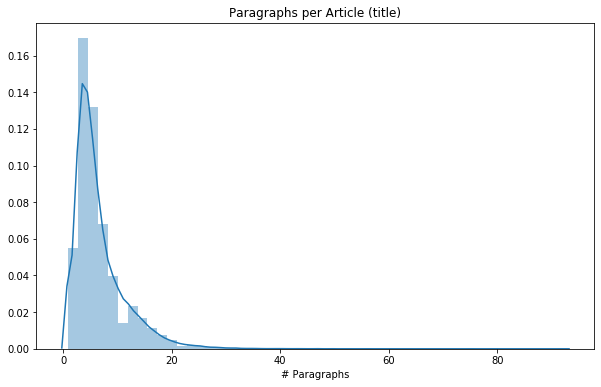

In [11]:
%matplotlib inline 
import seaborn as sns
import matplotlib.pyplot as plt 

fig, axes = plt.subplots(1,1, figsize = (10,6)) 
sns.distplot(sepdata_v1[['title','text']].groupby('title').agg('count')['text'].values, 
            ax=axes, axlabel = '# Paragraphs').set_title('Paragraphs per Article (title)')
# majority of our paragarphsgenerally 

## II. Begin cleaning text of paragraphs 

In [ ]:
# Define a text cleaner 
# Drawn heavily with reference from here 
# https://www.analyticsvidhya.com/blog/2019/06/comprehensive-guide-text-summarization-using-deep-learning-python/

In [13]:
import re #for regex search purposes          
from nltk.corpus import stopwords #stopwords that are provided to us via nltk 
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
import math

In [14]:
# List of contractions that we will map to 

contraction_mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",

                           "didn't": "did not", "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",

                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",

                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",

                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",

                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",

                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",

                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",

                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",

                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",

                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",

                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",

                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",

                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",

                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",

                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",

                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",

                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",

                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",

                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",

                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",

                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",

                           "you're": "you are", "you've": "you have"}

In [43]:
stop_words = set(stopwords.words('english')) 
def text_cleaner(text):
    # Step 0: Convert to string in case a float or int is found.
    newString = str(text)
    # Step 1: Lower case the text 
    newString = newString.lower()
    # Step 2: Get rid of commas
    newString = re.sub(r'\([^)]*\)', '', newString)
    # Step 3: Get rid of quotations 
    newString = re.sub('"','', newString)
    # Step 4: get rid of contractions with our contraction mapping 
    newString = ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in newString.split(" ")])  
    # Step 5: get rid of the \n stuff 
    newString = re.sub(r"'s\n","",newString)
    # Step 6: anything that is a number, get rid of it 
    newString = re.sub("[^a-zA-Z]", " ", newString) 
    # Step 7: Tokenize everything first and keep the words that are not stop words 
    # Also keep only words that are greater than or equal to 3 characters long 
    tokens = [w for w in newString.split() if not w in stop_words]
    long_words=[]
    for i in tokens:
        if len(i)>=3: #removing short words
            long_words.append(i)   
    return (" ".join(long_words)).strip()

In [50]:
# repeat the same step for the headlines, but with some variation on cleaning 

def headline_cleaner(text):
    # Step 0: Convert to string in case a float or int is found.
    newString = str(text)
    # Step 1: remove quotations 
    newString = re.sub('"','', newString)
    # Step 2: look up contractions 
    newString = ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in newString.split(" ")]) 
    # Step 3: Get rid of the \n stuff 
    newString = re.sub(r"'s\n","",newString)
    # Step 4: Get rid of numbers or anything not in the alphabet
    newString = re.sub("[^a-zA-Z]", " ", newString)
    # Step 5: Lower case 
    newString = newString.lower()
    tokens=newString.split()
    # Step 6: keep words that are greater than 1 character long 
    remaining=[]
    for i in tokens:
        if len(i)>1:                                 
            remaining.append(i) 
    return (" ".join(remaining)).strip()

In [54]:
sepdata_v1.shape

(1387289, 5)

In [56]:
clean_data = pd.DataFrame()

clean_data['text'] = sepdata_v1['text'].apply(text_cleaner)

clean_data['headline'] = sepdata_v1['headline'].apply(headline_cleaner)

In [57]:
clean_data.shape

(1387289, 2)

In [59]:
clean_data.to_csv('cleaned_wikihowsep.csv')

In [60]:
from sklearn.model_selection import train_test_split

In [68]:
train_text, test_text, train_headline, test_headline = train_test_split(clean_data['text'], 
                                                                        clean_data['headline'], 
                                                                        test_size=0.4, random_state=0) 

In [69]:
cv_text, test_text, cv_headline, test_headline = train_test_split(test_text, 
                                                                        test_headline, 
                                                                        test_size=0.125, random_state=0) 

In [70]:
train_text[0]

'anything else stop sum artist think translate online profile words twitter allows entire page indulgence website would allow bring salient features creativity experience passion reasons painting make clear readers artist loves art produces high quality art true champion art great words find friend help really important aspect selling online establishment credibility reliability'

In [71]:
sepdata['text'][0]
#Preprocessing has made the text difficult for humans to understand (let alone summarize). Maybe that's the language of the machine. Good luck buddy!


" Before doing anything else, stop and sum up yourself as an artist. Now, think about how to translate that to an online profile. Be it the few words, Twitter allows you or an entire page of indulgence that your own website would allow you. Bring out the most salient features of your creativity, your experience, your passion, and your reasons for painting. Make it clear to readers why you are an artist who loves art, produces high quality art, and is a true champion of art. If you're not great with words, find a friend who can help you with this really important aspect of selling online – the establishment of your credibility and reliability.;\n"

In [72]:
train_headline[0]

'sell yourself first'

In [77]:
vars = [train_text, cv_text, test_text, train_headline,cv_headline, test_headline]
for var in vars:
    print(var.shape)

#Sizes look fine and are in the ratio we expect : .6, .35 and .05.

(832373,)
(485551,)
(69365,)
(832373,)
(485551,)
(69365,)


In [ ]:
##### 
#Final bit of exploration: 
#### 

In [ ]:
# Get a sense of our max input and output lengths 

In [80]:
wordcount_intext = []
wordcount_inheadline = []

for i in clean_data['text']: 
    wordcount_intext.append(len(i.split()))
    
for i in clean_data['headline']: 
    wordcount_inheadline.append(len(i.split()))

In [92]:
wordcount_intext1 = [i for i in wordcount_intext if i<250]

In [93]:
wordcount_inheadline1 = [i for i in wordcount_inheadline if i<50]

Text(0.5, 1.0, 'Headline Word Count')

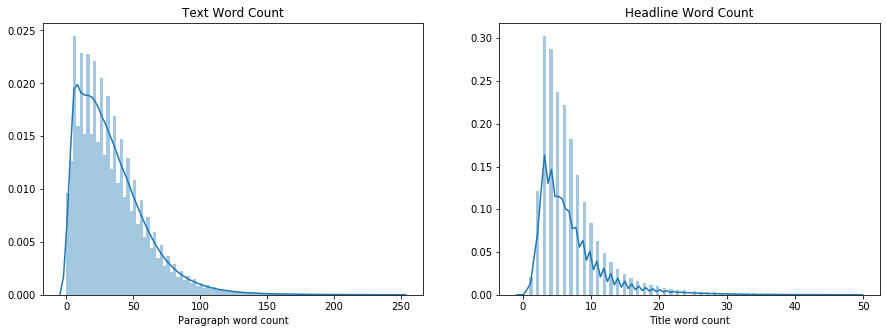

In [94]:
# Generally, what's the average word count in our headline and paragraph text? 

fig, axes = plt.subplots(1,2, figsize = (15,5)) 
sns.distplot(wordcount_intext1, bins=100, ax=axes[0], axlabel = 'Paragraph word count').set_title('Text Word Count')
sns.distplot(wordcount_inheadline1, bins=100, ax=axes[1], axlabel = 'Title word count').set_title('Headline Word Count')
# so it looks like title word count is muuuuch lower 

In [95]:
# rough statistics 
print('mean count of words in paragraphs: ' + str(np.nanmean(wordcount_intext)))
print('standard deviation of words in paragraphs: '+str(np.nanstd(wordcount_intext)))

mean count of words in paragraphs: 33.98637918991645
standard deviation of words in paragraphs: 27.23508579516612


In [96]:
# rough statistics 
print('mean count of words in headlines: ' + str(np.nanmean(wordcount_inheadline)))
print('standard deviation of words in headliness: '+str(np.nanstd(wordcount_inheadline)))

mean count of words in headlines: 7.112406283045566
standard deviation of words in headliness: 5.661153457812979


Text(0.5, 1.0, 'Cumulative Freq for Word Count in Text')

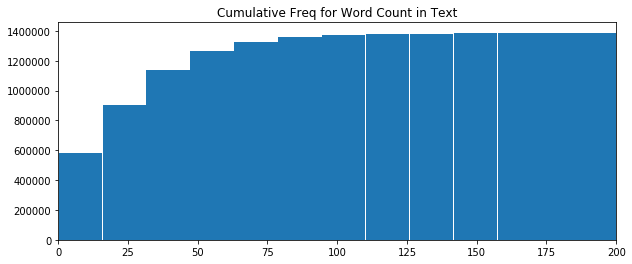

In [97]:
# cumulative distribution for better understanding of where we can cut off: 
from scipy import stats
wordcount_freq = stats.cumfreq(wordcount_intext, numbins=100)
x = wordcount_freq.lowerlimit + np.linspace(0, wordcount_freq.binsize*wordcount_freq.cumcount.size, 
                                            wordcount_freq.cumcount.size)
fig = plt.figure(figsize=(10, 4))
ax1 = fig.add_subplot(1,1,1)
ax1.bar(x, wordcount_freq.cumcount, width = wordcount_freq.binsize)
ax1.set_xlim([0, 200])
ax1.set_title('Cumulative Freq for Word Count in Text')
# looks like if we shorten down to just 200 words in text, we'll still get majority 

Text(0.5, 1.0, 'Cumulative Freq for Word Count in Headline')

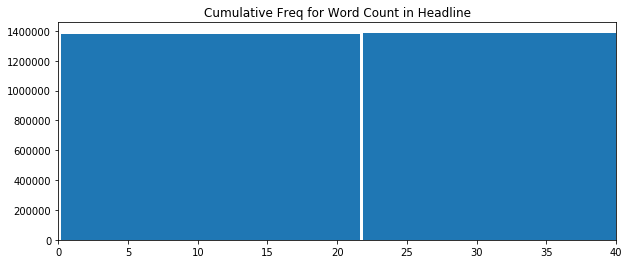

In [98]:
wordcount_summary_freq = stats.cumfreq(wordcount_inheadline, numbins=100)
x = wordcount_summary_freq.lowerlimit + np.linspace(0, wordcount_summary_freq.binsize*wordcount_summary_freq.cumcount.size, 
                                            wordcount_summary_freq.cumcount.size)
fig = plt.figure(figsize=(10, 4))
ax1 = fig.add_subplot(1,1,1)
ax1.bar(x, wordcount_summary_freq.cumcount, width = wordcount_summary_freq.binsize)
ax1.set_xlim([0,40])
ax1.set_title('Cumulative Freq for Word Count in Headline')
# Looks like if we shorten down to just 40 words in headline, we'll still be fine for summary 




In [99]:
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [107]:
#preparing a tokenizer for summary on training data 
tokenizer = Tokenizer()
tokenizer.fit_on_texts(list(train_text) + list(train_headline)) #Fit on all training text

In [108]:
def prep_for_keras(data, maxlen):
    
    return pad_sequences(tokenizer.texts_to_sequences(train_text), 
                                    maxlen=maxlen, padding='post')

In [109]:
#train_text, cv_text, test_text, train_headline,cv_headline, test_headline
max_length_text = 30
max_length_headline = 15

#convert summary sequences into integer sequences and pad upto max length
train_text_seq    =   prep_for_keras(train_text, max_length_text)
cv_text_seq    =   prep_for_keras(cv_text, max_length_text)
test_text_seq    =   prep_for_keras(test_text, max_length_text)

train_headline_seq    =   prep_for_keras(train_headline, max_length_headline)
cv_headline_seq    =   prep_for_keras(cv_headline, max_length_headline)
test_headline_seq    =   prep_for_keras(test_headline, max_length_headline)

In [114]:
train_text_seq[:2]

array([[ 102, 9464, 2715,   13,   85, 3289, 4745,  571,   93, 3289,  401,
         709,  273, 9464, 2001,  735,  486, 1476, 2715,  414,  235, 3289,
           0,    0,    0,    0,    0,    0,    0,    0],
       [5888, 4138, 2399,  375,  655,  106, 1516, 5595,  911, 4134, 2598,
        1253,  451,  899, 2837, 2832, 7507, 1748, 4582, 3574, 7342, 5486,
          49,  244,  127,  605,   11,   90,  589,   50]], dtype=int32)

In [112]:
train_headline_seq[:2]

array([[ 571,   93, 3289,  401,  709,  273, 9464, 2001,  735,  486, 1476,
        2715,  414,  235, 3289],
       [2832, 7507, 1748, 4582, 3574, 7342, 5486,   49,  244,  127,  605,
          11,   90,  589,   50]], dtype=int32)

In [115]:
voc_size  =   len(tokenizer.word_index) +1
#Voc_size is 131998